In [32]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用中文宋体字体

## 一、相关软件包的导入

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import DataLoader, BatchSampler, Dataset

import os
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import random

## 二、设置随机种子和GPU的使用

In [28]:
def set_seed(seed):
    """
    设置所有随机种子，以消除cuda内核的任何随机性。

    """
    random.seed(seed)  # 设置Python的随机种子
    np.random.seed(seed)  # 设置NumPy的随机种子
    torch.manual_seed(seed)  # 设置PyTorch的CPU随机种子
    torch.cuda.manual_seed_all(seed)  # 设置所有GPU的随机种子

    # 禁用cuDNN的自动调谐器以确保每次使用相同的算法
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    return True

# 设置设备为CPU或GPU
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")  # 检测到GPU时，使用GPU
    device = 'cuda'
else:
    print("No GPU available!")  # 否则使用CPU

Cuda installed! Running on GPU!


## 三、自定义数据集用于数据的导入

In [29]:
import os
from PIL import Image, UnidentifiedImageError
import json
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class StormDataset(Dataset):
    """
    自定义数据集类，用于处理用于预测的风暴图像序列。

    Args:
        root (str): 包含风暴图像数据的根目录。
        transform (bool, optional): 是否应用图像转换。默认为 True。
        sequence_length (int, optional): 图像序列的长度。默认为 5。
        stride (int, optional): 图像序列的步长。默认为 1。
        folder (str, optional): 包含风暴数据的子文件夹。默认为 None。
    """

    def __init__(self, root, transform=True, sequence_length=5, stride=1, folder=None):
        self.transform = transform
        self.root = root
        self.sequence_length = sequence_length
        self.folder = folder
        self.stride = stride
        self.data = self._get_all_storm_sequences()

    def _get_all_storm_sequences(self):
        all_sequences = []
        if self.folder:
            # 仅考虑一个特定的文件夹
            storm_path = os.path.join(self.root, self.folder)
            storm_sequences = self._get_storm_sequences(storm_path)
            for seq in storm_sequences:
                all_sequences.append(seq)
        else:
            # 遍历所有文件夹
            for storm_folder in os.listdir(self.root):
                storm_path = os.path.join(self.root, storm_folder)
                if os.path.isdir(storm_path):
                    storm_sequences = self._get_storm_sequences(storm_path)
                    for seq in storm_sequences:
                        all_sequences.append(seq)
        return all_sequences

    def _get_storm_sequences(self, storm_path):
        '''将风暴拆分为序列'''
        paths = self._get_image_paths(storm_path)
        sequences = []
        for i in range(0, len(paths) - self.sequence_length, self.stride):
            sequence = paths[i:i + self.sequence_length]
            sequences.append(sequence)
        return sequences

    def _get_image_paths(self, storm_path, exts=(".jpg")):
        data = []
        for root, dirs, files in os.walk(storm_path):
            for file in files:
                if file.endswith(exts):
                    img_path = os.path.join(root, file)
                    num_path = img_path.removesuffix('.jpg')
                    try:
                        features_path = num_path + "_features.json"
                        if os.path.exists(features_path):
                            with open(features_path, 'r') as f:
                                features = json.load(f)
                                time_feature = features.get('relative_time')
                                if time_feature is not None:
                                    data.append((img_path, int(time_feature)))
                    except UnidentifiedImageError:
                        print('image error')
                        pass
        data.sort(key=lambda x: x[1])
        return [item[0] for item in data]

    def __getitem__(self, idx):
        sequence_paths = self.data[idx]
        images = []
        for img_path in sequence_paths[:-1]:
            img = Image.open(img_path).convert('L')
            if self.transform:
                transform = transforms.Compose([
                    transforms.Resize((336, 336)),
                    transforms.ToTensor()
                ])
                img = transform(img)
            images.append(img)

        target_img_path = sequence_paths[-1]
        target_img = Image.open(target_img_path).convert('L')
        if self.transform:
            target_img = transform(target_img)

        return torch.stack(images), target_img

    def __len__(self):
        return len(self.data)

    def __str__(self):
        class_string = self.__class__.__name__
        class_string += f"\n\tlen : {self.__len__()}"
        for key, value in self.__dict__.items():
            class_string += f"\n\t{key} : {value}"
        return class_string


In [30]:
dataset_root = r"F:\实验课及其实验报告\大数据分析实验\storm"
dataset = StormDataset(root=dataset_root, transform=True, sequence_length=6, stride=1)

## 四、检查数据集的前几个样本

样本 0:
- 图像序列长度: 5
- 每个图像的形状: torch.Size([1, 336, 336])
- 目标图像的形状: torch.Size([1, 336, 336])


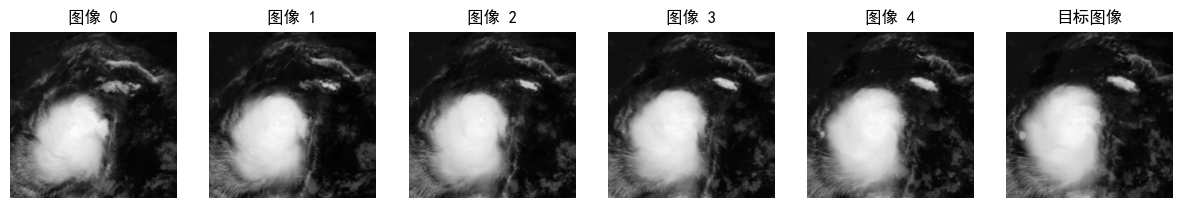

样本 1:
- 图像序列长度: 5
- 每个图像的形状: torch.Size([1, 336, 336])
- 目标图像的形状: torch.Size([1, 336, 336])


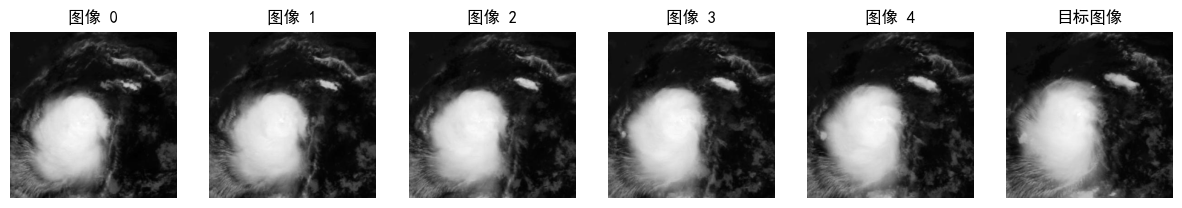

样本 2:
- 图像序列长度: 5
- 每个图像的形状: torch.Size([1, 336, 336])
- 目标图像的形状: torch.Size([1, 336, 336])


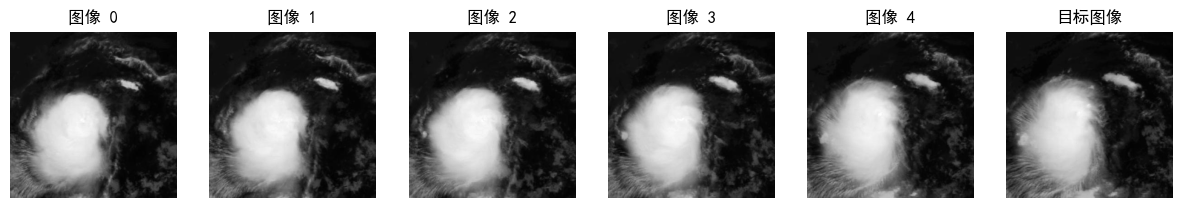

In [33]:
# 检查数据集中的前几个样本
num_items_to_check = 3

# 遍历前几个样本
for i in range(num_items_to_check):
    # 获取第i个样本的图像序列和目标图像
    images, target_image = dataset[i]
    print(f"样本 {i}:")
    print(f"- 图像序列长度: {len(images)}")
    print(f"- 每个图像的形状: {images[0].shape}")
    print(f"- 目标图像的形状: {target_image.shape}")

    # 可选择显示图像
    fig, axs = plt.subplots(1, len(images) + 1, figsize=(15, 5))

    # 显示图像序列
    for j, img in enumerate(images):
        axs[j].imshow(img.squeeze(), cmap='gray')
        axs[j].set_title(f"图像 {j}")
        axs[j].axis('off')

    # 显示目标图像
    axs[-1].imshow(target_image.squeeze(), cmap='gray')
    axs[-1].set_title("目标图像")
    axs[-1].axis('off')

    plt.show()


## 五、模型的建立

In [34]:
# 定义一个 ConvLSTM 单元
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        # 定义包含四个卷积层的卷积网络，用于处理输入和隐藏状态
        self.conv = nn.Conv2d(in_channels=self.input_channels + self.hidden_channels,
                              out_channels=4 * self.hidden_channels,
                              kernel_size=self.kernel_size,
                              padding=self.padding)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        # 拼接输入张量和当前隐藏状态
        combined = torch.cat([input_tensor, h_cur], dim=1)
        # 将拼接后的张量输入到卷积层
        combined_conv = self.conv(combined)
        # 应用 ELU 激活函数
        combined_conv = F.elu(combined_conv)

        # 将卷积输出张量拆分为四个部分，分别代表输入门、遗忘门、输出门和候选值
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_channels, dim=1)
        # 计算输入门、遗忘门、输出门和候选值
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        # 更新细胞状态和隐藏状态
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        device = next(self.parameters()).device
        # 初始化细胞状态和隐藏状态，全零张量
        return (torch.zeros(batch_size, self.hidden_channels, height, width, device=device),
                torch.zeros(batch_size, self.hidden_channels, height, width, device=device))

# 定义卷积编码器类
class ConvEncoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, dropout_prob=0.7):
        super(ConvEncoder, self).__init__()
        # 定义 ConvLSTM 单元作为编码器的第一层
        self.conv_lstm1 = ConvLSTMCell(input_channels, hidden_channels // 2, kernel_size)

        # 批归一化层和二维 dropout 层
        self.batch_norm = nn.BatchNorm2d(hidden_channels // 2)
        self.dropout = nn.Dropout2d(dropout_prob)

    def forward(self, input_tensor):
        batch_size, seq_len, _, height, width = input_tensor.size()
        # 初始化隐藏状态和细胞状态
        h, c = self.conv_lstm1.init_hidden(batch_size, (height, width))
        last_state = None

        for t in range(seq_len):
            # 更新隐藏状态和细胞状态
            h, c = self.conv_lstm1(input_tensor[:, t, :, :, :], (h, c))

            # 应用批归一化和 dropout
            h = self.batch_norm(h)
            h = self.dropout(h)
            if t == seq_len - 1:
                last_state = h

        return last_state, (h, c)

# 定义卷积解码器类
class ConvDecoder(nn.Module):
    def __init__(self, hidden_channels, output_channels, kernel_size, dropout_prob=0.7):
        super(ConvDecoder, self).__init__()
        # 定义 ConvLSTM 单元作为解码器的第一层
        self.conv_lstm1 = ConvLSTMCell(hidden_channels // 2, hidden_channels // 2, kernel_size)
        self.batch_norm = nn.BatchNorm2d(hidden_channels // 2)
        self.conv = nn.Conv2d(hidden_channels // 2, output_channels, kernel_size=1)
        self.dropout = nn.Dropout2d(dropout_prob)

    def forward(self, encoder_last_state, h, c, seq_len):
        outputs = []

        for t in range(seq_len):
            # 更新隐藏状态和细胞状态
            h, c = self.conv_lstm1(h, (h, c))
            h = self.batch_norm(h)
            if t == 0:
                # 将编码器最后状态加到解码器的第一步
                h = h + encoder_last_state
            # 应用 dropout
            h = self.dropout(h)
            outputs.append(h)

        # 将输出转换为最终输出张量
        output = self.conv(outputs[-1])
        output = output.unsqueeze(1)

        return output

# 定义序列到序列自动编码器类
class Seq2SeqAutoencoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, kernel_size):
        super(Seq2SeqAutoencoder, self).__init__()
        # 初始化编码器和解码器
        self.encoder = ConvEncoder(input_channels, hidden_channels, kernel_size)
        self.decoder = ConvDecoder(hidden_channels, output_channels, kernel_size)

    def forward(self, input_tensor):
        # 编码输入序列
        # 获得编码器最终状态
        encoder_last_state, (h, c) = self.encoder(input_tensor)
        # 使用解码器生成输出
        output = self.decoder(encoder_last_state, h, c, seq_len=1)
        return output

# 模型初始化参数
input_channels = 1
hidden_channels = 128
output_channels = 1
kernel_size = 1
sequence_length = 5

# 创建 Seq2Seq 自动编码器模型
model = Seq2SeqAutoencoder(input_channels, hidden_channels, output_channels, kernel_size)

# 测试模型
input_tensor = torch.rand(1, sequence_length, input_channels, 224, 224)
output = model(input_tensor)
print(output.shape)  # 检查输出形状


torch.Size([1, 1, 1, 224, 224])


## 六、训练模型函数和评估模型函数

In [35]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

def train(model, dataloader, optimizer, device):
    """
    训练模型函数。

    Args:
        model (torch.nn.Module): 要训练的模型。
        dataloader (torch.utils.data.DataLoader): 用于加载训练数据的数据加载器。
        optimizer (torch.optim.Optimizer): 优化器，用于更新模型参数。
        device (torch.device): 计算设备。

    Returns:
        float: 训练过程中的平均损失值。
    """
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        # 移除序列长度维度，但保留通道维度
        outputs = outputs.squeeze(2)

        # 计算 SSIM 损失
        loss = 1 - ssim(outputs, targets, data_range=255, size_average=True)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    """
    评估模型函数。

    Args:
        model (torch.nn.Module): 要评估的模型。
        dataloader (torch.utils.data.DataLoader): 用于加载验证或测试数据的数据加载器。
        device (torch.device): 计算设备。

    Returns:
        float: 评估过程中的平均损失值。
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = outputs.squeeze(2)

            # 计算 SSIM 分数
            ssim_score = ssim(outputs, targets, data_range=255, size_average=True)
            loss = 1 - ssim_score

            total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    return average_loss


## 七、划分数据集

In [16]:
# 确定数据集划分大小
total_size = len(dataset)  # 获取数据集总大小
train_size = int(0.7 * total_size)  # 训练集大小为总大小的70%
val_size = int(0.15 * total_size)   # 验证集大小为总大小的15%
test_size = total_size - (train_size + val_size)  # 测试集大小为剩余的大小

# 将数据集划分为训练集、验证集和测试集
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])


## 八、定义批处理大小

In [37]:
# 定义批处理大小
batch_size = 5

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 训练数据加载器，随机打乱顺序
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)     # 验证数据加载器，不需要打乱顺序
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    # 测试数据加载器，不需要打乱顺序


## 九、损失函数

In [23]:
# 绘制损失函数曲线
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='训练损失', marker='o')  # 训练损失
    plt.plot(epochs, val_losses, label='验证损失', marker='o')  # 验证损失
    plt.title('训练和验证损失')  # 标题
    plt.xlabel('轮次')  # x轴标签
    plt.ylabel('损失')  # y轴标签
    plt.legend()  # 图例
    plt.grid(True)  # 显示网格
    plt.show()  # 显示图形


## 十、循环训练和模型的保存

In [ ]:
# 优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30  # 总共训练30个周期

for epoch in range(num_epochs):
    # 训练模型，并获取训练损失
    train_loss = train(model, train_loader, optimizer, device)
    
    # 评估模型，并获取验证损失
    val_loss = evaluate(model, val_loader, device)
    
    # 打印训练和验证损失
    print(f"第 {epoch+1} 个周期, 训练损失: {train_loss}, 验证损失: {val_loss}")

In [ ]:
torch.save(model.state_dict(), 'F:\实验课及其实验报告\大数据分析实验\task1_model.pth')

In [ ]:
model = Seq2SeqAutoencoder(input_channels, hidden_channels, output_channels, kernel_size)
model.load_state_dict(torch.load('F:\实验课及其实验报告\大数据分析实验\task1_model.pth'))

In [ ]:
#绘制损失曲线

In [ ]:
# 记录训练和验证损失
train_losses.append(train_loss)
val_losses.append(val_loss)
    

plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## 十一、预测

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def get_last_tensors():
    image_directory = "F:\实验课及其实验报告\大数据分析实验\tst"

    # 获取目录中所有 .jpg 文件的路径
    image_files = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.endswith('.jpg')]

    # 对文件路径进行排序
    image_files.sort()

    # 获取最后四张图片的路径
    last_four_images = image_files[-4:]

    # 可视化最后四张图片
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i, img_path in enumerate(last_four_images):
        img = Image.open(img_path).convert('L')  # 打开并转换为灰度图像
        axes[i].imshow(img, cmap='gray')  # 显示图片
        axes[i].axis('off')  # 不显示坐标轴
        axes[i].set_title(f'Image {i+1}')  # 设置标题

    plt.tight_layout()
    plt.show()

    # 转换最后四张图片为张量
    images = []
    for img_path in last_four_images:
        img = Image.open(img_path).convert('L')  # 打开并转换为灰度图像
        transform = transforms.Compose([
            transforms.Resize((336, 336)),  # 调整大小
            transforms.ToTensor()  # 转换为张量
        ])
        img = transform(img)
        images.append(img)

    # 堆叠张量并添加批次维度
    last_tensors = torch.stack(images).unsqueeze(0)
    last_three = torch.stack(images[-3:]).unsqueeze(0)
    last_two = torch.stack(images[-2:]).unsqueeze(0)

    return last_tensors, last_three, last_two

# 调用函数并输出最后四张图片及其张量
last_tensors, last_three, last_two = get_last_tensors()
print("Last four tensors:", last_tensors.shape)
print("Last three tensors:", last_three.shape)
print("Last two tensors:", last_two.shape)


In [ ]:
# 获取最后四张图像的张量表示
last_tensors, last_three, last_two  = get_last_tensors()

# last_tensors 包含最后四张图像的张量表示
# last_three 包含最后三张图像的张量表示
# last_two 包含最后两张图像的张量表示

In [ ]:
# 进行预测
def make_prediction(model, device, last_tensors):
    # 将模型设置为评估模式
    model.eval()
    # 将模型移动到指定设备（GPU）
    model.to(device)

    # 禁用梯度计算
    with torch.no_grad():
        # 将输入数据移动到指定设备（GPU）
        last_tensors = last_tensors.to(device)
        # 使用模型进行预测
        prediction = model(last_tensors)

    return prediction


In [ ]:
# 进行第一次预测
prediction_1 = make_prediction(model, device, last_tensors)

# 将最后三张图像的张量和第一次预测结果连接起来
last_three = last_three.to(device)
last_tensors_2 = torch.cat((last_three, prediction_1), dim=1)

# 进行第二次预测
prediction_2 = make_prediction(model, device, last_tensors_2)

# 将最后两张图像的张量、第一次预测结果和第二次预测结果连接起来
last_two = last_two.to(device)
last_tensors_3 = torch.cat((last_two, prediction_1, prediction_2), dim=1)

# 进行最终预测
prediction_3 = make_prediction(model, device, last_tensors_3)


## 十二、图像的保存和输出

In [ ]:
# 保存张量为图像
def save_tensor(tensor, i):
    # 压缩张量的维度
    tensor = tensor.squeeze()

    # 将张量归一化到[0, 1]范围
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())

    # 确保张量的数据类型为 float32 以便保存
    tensor = tensor.type(torch.FloatTensor)

    # 将张量保存为图像
    save_image(tensor, f'/content/gdrive/MyDrive/test_predict_{i}.jpg')

    # 显示图像
    plt.imshow(tensor.cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()


In [ ]:
save_tensor(prediction_1, 1)
save_tensor(prediction_2, 2)
save_tensor(prediction_3, 3)

## 十三、模型评价

In [ ]:
# 选择其中一张最后四张图片作为原始图像
original_image = last_tensors.to(device)[0, -1]  # 选择最后一张图片作为原始图像，并将其移动到设备上

# 计算每个预测图像与原始图像的PSNR和MSE
psnr_1 = PSNR(original_image, prediction_1)
mse_1 = MSE(original_image, prediction_1)

psnr_2 = PSNR(original_image, prediction_2)
mse_2 = MSE(original_image, prediction_2)

psnr_3 = PSNR(original_image, prediction_3)
mse_3 = MSE(original_image, prediction_3)

print("预测1 PSNR:", psnr_1.item(), "MSE:", mse_1.item())
print("预测2 PSNR:", psnr_2.item(), "MSE:", mse_2.item())
print("预测3 PSNR:", psnr_3.item(), "MSE:", mse_3.item())
